In [ ]:
# ============================================
# CELL 1: Install Required Packages for YOLO12
# ============================================
# Install latest ultralytics for YOLO12 support
!pip install --upgrade ultralytics roboflow

import os
import glob
import pathlib
from roboflow import Roboflow
from ultralytics import YOLO
from google.colab import drive

In [ ]:
# ============================================
# CELL 2: Mount Google Drive
# ============================================
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================
# CELL 3: Configuration Class for YOLO12
# ============================================
import json
from datetime import datetime

class TrainingConfig:
    """Centralized training configuration for YOLO12"""
    def __init__(self):
        # Paths
        self.drive_base_path = "/content/drive/MyDrive/FireDetection"
        self.checkpoint_dir = f"{self.drive_base_path}/checkpoints"
        self.output_model_path = f"{self.drive_base_path}/fire_detection_yolo12.pt"
        self.training_state_file = f"{self.checkpoint_dir}/training_state.json"

        # Training parameters - YOLO12 Models
        # Options: yolo12n.pt, yolo12s.pt, yolo12m.pt, yolo12l.pt, yolo12x.pt
        self.model_size = "yolo12s.pt"  # Nano - fastest
        # self.model_size = "yolo12s.pt"  # Small - balanced (RECOMMENDED)
        # self.model_size = "yolo12m.pt"  # Medium - more accurate

        self.epochs = 100
        self.batch_size = 16
        self.imgsz = 640
        self.save_period = 10  # Save checkpoint every N epochs

        # Dataset configuration - YOLO12 format
        self.roboflow_api_key = "qyGcSlfbaPmDBDe4mcU8"
        self.workspace = "cell-jff2n"
        self.project = "fire-detection-rsqrr-rkytc"
        self.version = 1

        # Create directories
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        print(f"✅ YOLO12 Configuration initialized")
        print(f"   - Model: {self.model_size}")
        print(f"   - Checkpoint directory: {self.checkpoint_dir}")
        print(f"   - Output model: {self.output_model_path}")

# Initialize configuration
config = TrainingConfig()

✅ YOLO12 Configuration initialized
   - Model: yolo12s.pt
   - Checkpoint directory: /content/drive/MyDrive/FireDetection/checkpoints
   - Output model: /content/drive/MyDrive/FireDetection/fire_detection_yolo12.pt


In [ ]:
# ============================================
# CELL 4: Training State Manager
# ============================================
class TrainingStateManager:
    """Manage training state for easy resumption"""

    def __init__(self, config):
        self.config = config
        self.state_file = config.training_state_file

    def save_state(self, run_name, epoch, best_checkpoint, last_checkpoint):
        """Save current training state"""
        state = {
            'run_name': run_name,
            'last_epoch': epoch,
            'best_checkpoint': best_checkpoint,
            'last_checkpoint': last_checkpoint,
            'timestamp': datetime.now().isoformat(),
            'total_epochs': self.config.epochs,
            'model': self.config.model_size
        }

        with open(self.state_file, 'w') as f:
            json.dump(state, f, indent=2)

        print(f"✅ Training state saved: Epoch {epoch}/{self.config.epochs}")

    def load_state(self):
        """Load previous training state"""
        if os.path.exists(self.state_file):
            with open(self.state_file, 'r') as f:
                state = json.load(f)
            print(f"📂 Found previous training state:")
            print(f"   - Model: {state.get('model', 'N/A')}")
            print(f"   - Run: {state['run_name']}")
            print(f"   - Last epoch: {state['last_epoch']}/{state['total_epochs']}")
            print(f"   - Timestamp: {state['timestamp']}")
            return state
        return None

    def clear_state(self):
        """Clear training state"""
        if os.path.exists(self.state_file):
            os.remove(self.state_file)
            print("🗑️ Training state cleared")

# Initialize state manager
state_manager = TrainingStateManager(config)

In [ ]:
# ============================================
# CELL 5: Checkpoint Finder Function
# ============================================
def find_best_checkpoint(checkpoint_dir):
    """
    Find the best checkpoint to resume from
    Returns: (checkpoint_path, run_dir, run_name) or (None, None, None)
    """
    print("\n🔍 Searching for checkpoints...")

    # Priority 1: Check training state file
    state = state_manager.load_state()
    if state and os.path.exists(state['last_checkpoint']):
        run_dir = os.path.dirname(os.path.dirname(state['last_checkpoint']))
        run_name = os.path.basename(run_dir)
        print(f"✅ Found checkpoint from state file: {state['last_checkpoint']}")
        return state['last_checkpoint'], run_dir, run_name

    # Priority 2: Search for last.pt files in checkpoint directory
    checkpoint_patterns = [
        f"{checkpoint_dir}/**/weights/last.pt",
        f"{checkpoint_dir}/**/last.pt",
    ]

    checkpoint_files = []
    for pattern in checkpoint_patterns:
        found = list(pathlib.Path(checkpoint_dir).rglob(pattern.split('**/')[-1]))
        checkpoint_files.extend(found)

    if checkpoint_files:
        # Get the most recent checkpoint
        latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
        weights_dir = os.path.dirname(latest_checkpoint)
        run_dir = os.path.dirname(weights_dir)
        run_name = os.path.basename(run_dir)

        print(f"✅ Found checkpoint: {latest_checkpoint}")
        print(f"   - Run directory: {run_dir}")
        print(f"   - Modified: {datetime.fromtimestamp(os.path.getctime(latest_checkpoint))}")

        return str(latest_checkpoint), str(run_dir), run_name

    print("ℹ️ No checkpoint found - will start fresh training")
    return None, None, None

# Test the checkpoint finder
checkpoint_path, run_dir, run_name = find_best_checkpoint(config.checkpoint_dir)



🔍 Searching for checkpoints...
✅ Found checkpoint: /content/drive/MyDrive/FireDetection/checkpoints/face_emotion_yolo12_20251205_162717/weights/last.pt
   - Run directory: /content/drive/MyDrive/FireDetection/checkpoints/face_emotion_yolo12_20251205_162717
   - Modified: 2025-12-05 18:48:01


In [ ]:
# ============================================
# CELL 6: Dataset Download Function for YOLO12
# ============================================
def download_dataset(config):
    """Download dataset from Roboflow in YOLO12 format"""
    print("\n📦 Downloading dataset from Roboflow (YOLO12 format)...")

    rf = Roboflow(api_key=config.roboflow_api_key)
    project = rf.workspace(config.workspace).project(config.project)
    version = project.version(config.version)

    # Download in YOLO12 format
    dataset = version.download("yolov12")

    print(f"✅ Dataset downloaded to: {dataset.location}")
    return dataset

# Download dataset (run this once)
dataset = download_dataset(config)


📦 Downloading dataset from Roboflow (YOLO12 format)...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fire-detection-1 in yolov12:: 100%|██████████| 7412/7412 [00:00<00:00, 7512.40it/s]

✅ Dataset downloaded to: /content/fire-detection-1


In [ ]:
# ============================================
# CELL 7: Training Setup Function for YOLO12
# ============================================
def setup_training(config, dataset, force_restart=False):
    """
    Setup YOLO12 training with automatic resume capability

    Args:
        config: TrainingConfig instance
        dataset: Downloaded dataset
        force_restart: If True, ignore checkpoints and start fresh

    Returns:
        model, training_args dictionary
    """
    print("\n" + "="*60)
    print("YOLO12 TRAINING SETUP")
    print("="*60)

    # Find checkpoint
    checkpoint_path, run_dir, run_name = None, None, None

    if not force_restart:
        checkpoint_path, run_dir, run_name = find_best_checkpoint(config.checkpoint_dir)
    else:
        print("🔄 Force restart enabled - starting fresh training")
        state_manager.clear_state()

    # Setup training arguments (YOLO12 optimized)
    training_args = {
        'data': f"{dataset.location}/data.yaml",
        'epochs': config.epochs,
        'imgsz': config.imgsz,
        'batch': config.batch_size,
        'save_period': config.save_period,
        'project': config.checkpoint_dir,
        'amp': True,  # Automatic Mixed Precision
        'patience': 100,  # Early stopping patience
        'verbose': True,

        # YOLO12 specific optimizations
        'optimizer': 'auto',  # Let YOLO12 choose best optimizer
        'close_mosaic': 10,  # Disable mosaic in last 10 epochs for better accuracy
    }

    # Configure resume or fresh start
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"\n🔄 RESUMING TRAINING")
        print(f"   - Checkpoint: {checkpoint_path}")
        print(f"   - Run name: {run_name}")

        model = YOLO(checkpoint_path)

        training_args.update({
            'resume': True,
            'exist_ok': True,
            'name': run_name,
        })
    else:
        print(f"\n🆕 STARTING FRESH TRAINING")
        print(f"   - Model: {config.model_size}")

        # Initialize YOLO12 model
        model = YOLO(config.model_size)

        # Generate unique run name
        run_name = f"face_emotion_yolo12_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

        training_args.update({
            'resume': False,
            'exist_ok': False,
            'name': run_name,
        })

        print(f"   - New run name: {run_name}")

    print(f"\n📋 YOLO12 Training Configuration:")
    print(f"   - Epochs: {config.epochs}")
    print(f"   - Batch size: {config.batch_size}")
    print(f"   - Image size: {config.imgsz}")
    print(f"   - Save period: {config.save_period} epochs")
    print(f"   - Project: {config.checkpoint_dir}")

    return model, training_args

# Setup training (set force_restart=True to start fresh)
model, training_args = setup_training(config, dataset, force_restart=False)



YOLO12 TRAINING SETUP

🔍 Searching for checkpoints...
✅ Found checkpoint: /content/drive/MyDrive/FireDetection/checkpoints/face_emotion_yolo12_20251205_162717/weights/last.pt
   - Run directory: /content/drive/MyDrive/FireDetection/checkpoints/face_emotion_yolo12_20251205_162717
   - Modified: 2025-12-05 18:48:01

🔄 RESUMING TRAINING
   - Checkpoint: /content/drive/MyDrive/FireDetection/checkpoints/face_emotion_yolo12_20251205_162717/weights/last.pt
   - Run name: face_emotion_yolo12_20251205_162717

📋 YOLO12 Training Configuration:
   - Epochs: 100
   - Batch size: 16
   - Image size: 640
   - Save period: 10 epochs
   - Project: /content/drive/MyDrive/FireDetection/checkpoints


In [ ]:
# ============================================
# CELL 8: Main Training Function
# ============================================
def train_model(model, training_args, config):
    """
    Execute YOLO12 training with error handling
    """
    try:
        print("\n" + "="*60)
        print("🚀 STARTING YOLO12 TRAINING")
        print("="*60 + "\n")

        # Train model
        results = model.train(**training_args)

        print("\n" + "="*60)
        print("✅ TRAINING COMPLETED")
        print("="*60)

        # Save final model
        run_dir = f"{config.checkpoint_dir}/{training_args['name']}"
        best_model_path = f"{run_dir}/weights/best.pt"

        if os.path.exists(best_model_path):
            import shutil
            shutil.copy2(best_model_path, config.output_model_path)
            print(f"\n✅ Best YOLO12 model saved to: {config.output_model_path}")

        # Clear training state on successful completion
        state_manager.clear_state()

        return results

    except KeyboardInterrupt:
        print("\n⚠️ Training interrupted by user")
        # Save current state for resume
        checkpoint_path, run_dir, run_name = find_best_checkpoint(config.checkpoint_dir)
        if checkpoint_path:
            state_manager.save_state(
                run_name=run_name,
                epoch=0,  # Will be updated by YOLO
                best_checkpoint=checkpoint_path.replace('last.pt', 'best.pt'),
                last_checkpoint=checkpoint_path
            )
        raise

    except Exception as e:
        print(f"\n❌ Training failed: {str(e)}")

        # Log error
        error_log = f"{config.checkpoint_dir}/training_error.log"
        with open(error_log, "a") as f:
            f.write(f"\n{'='*50}\n")
            f.write(f"Timestamp: {datetime.now().isoformat()}\n")
            f.write(f"Error: {str(e)}\n")
            f.write(f"{'='*50}\n")

        raise

# Start training
results = train_model(model, training_args, config)



🚀 STARTING YOLO12 TRAINING

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/fire-detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/FireDetection/checkpoints/face_emotion_yolo12_20251205_162717/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=face_emotio


📊 YOLO12 MODEL VALIDATION
✅ Loaded YOLO12 model from: /content/drive/MyDrive/FireDetection/fire_detection_yolo12.pt
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,232,428 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 423.1±175.0 MB/s, size: 27.1 KB)
val: Scanning /content/fire-detection-1/valid/labels.cache... 309 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 309/309 75.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 20/20 2.0it/s 10.1s
                   all        309        313      0.874      0.792      0.866      0.494
                  fire         81         81      0.824      0.852      0.894      0.564
                 light         71         74      0.914      0.689      0.861      0.429
               no-fire         74         74      0.939      0.973      0.987      0.612
       

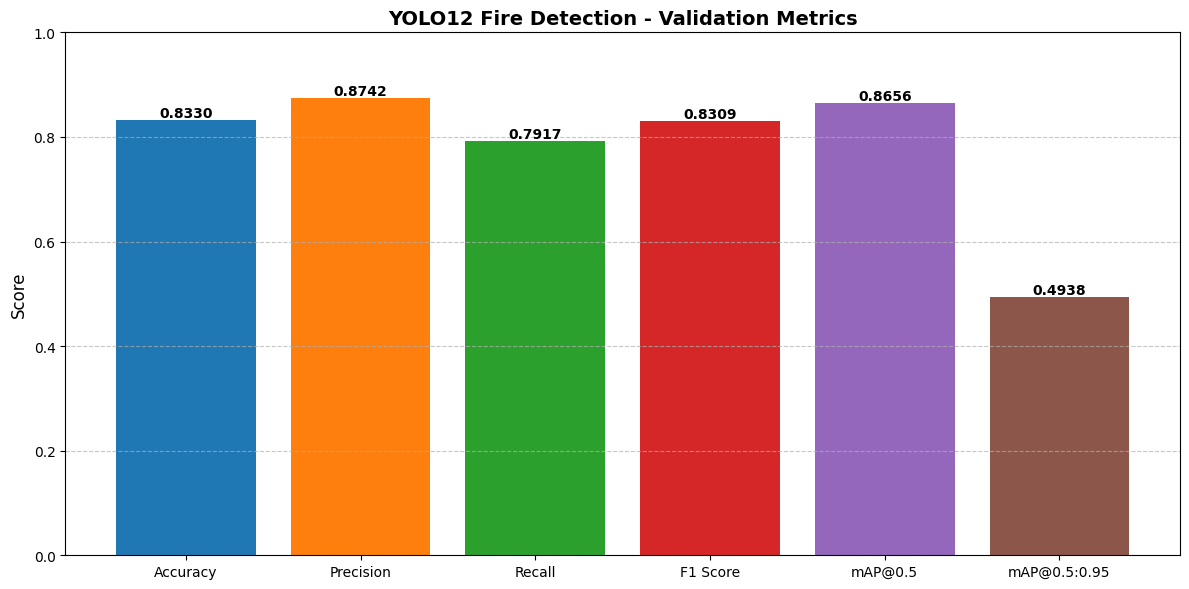


✅ Metrics plot saved to: /content/drive/MyDrive/FireDetection/checkpoints/yolo12_validation_metrics.png


In [ ]:
# ============================================
# CELL 9: Validation & Metrics
# ============================================
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*60)
print("📊 YOLO12 MODEL VALIDATION")
print("="*60)

# Load the best model
if os.path.exists(config.output_model_path):
    model = YOLO(config.output_model_path)
    print(f"✅ Loaded YOLO12 model from: {config.output_model_path}")
else:
    # Try to find the latest checkpoint
    checkpoint_path, _, _ = find_best_checkpoint(config.checkpoint_dir)
    if checkpoint_path:
        best_path = checkpoint_path.replace('last.pt', 'best.pt')
        if os.path.exists(best_path):
            model = YOLO(best_path)
            print(f"✅ Loaded YOLO12 model from: {best_path}")
        else:
            model = YOLO(checkpoint_path)
            print(f"✅ Loaded YOLO12 model from: {checkpoint_path}")
    else:
        print("❌ No model found for validation!")
        model = None

# Perform validation if model is available
if model is not None:
    try:
        results = model.val()

        if results is not None:
            # Extract metrics
            metrics = results.results_dict

            # Get metrics
            precision = metrics.get('metrics/precision(B)', 0)
            recall = metrics.get('metrics/recall(B)', 0)
            mAP50 = metrics.get('metrics/mAP50(B)', 0)
            mAP50_95 = metrics.get('metrics/mAP50-95(B)', 0)

            # Calculate F1 score and accuracy
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            accuracy = (precision + recall) / 2

            # Print metrics
            print("\n📈 YOLO12 Validation Metrics:")
            print(f"   - Accuracy:     {accuracy:.4f}")
            print(f"   - Precision:    {precision:.4f}")
            print(f"   - Recall:       {recall:.4f}")
            print(f"   - F1 Score:     {f1:.4f}")
            print(f"   - mAP@0.5:      {mAP50:.4f}")
            print(f"   - mAP@0.5:0.95: {mAP50_95:.4f}")

            # Plot metrics
            metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'mAP@0.5', 'mAP@0.5:0.95']
            metrics_values = [accuracy, precision, recall, f1, mAP50, mAP50_95]

            plt.figure(figsize=(12, 6))
            bars = plt.bar(metrics_names, metrics_values,
                          color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])

            # Add value labels on top of bars
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.4f}',
                        ha='center', va='bottom', fontsize=10, fontweight='bold')

            plt.title('YOLO12 Fire Detection - Validation Metrics', fontsize=14, fontweight='bold')
            plt.ylabel('Score', fontsize=12)
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()

            # Save plot
            plot_path = f"{config.checkpoint_dir}/yolo12_validation_metrics.png"
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            plt.show()

            print(f"\n✅ Metrics plot saved to: {plot_path}")
        else:
            print("❌ Validation failed to produce results!")
    except Exception as e:
        print(f"❌ Validation failed: {e}")


# END

In [ ]:
# ============================================
# CELL 10: Utility - Check Training Status
# ============================================
def check_training_status():
    """Check current training status"""
    print("\n" + "="*60)
    print("📋 YOLO12 TRAINING STATUS")
    print("="*60)

    # Check training state
    state = state_manager.load_state()
    if state:
        print(f"\n📂 Training State:")
        print(f"   - Model: {state.get('model', 'N/A')}")
        print(f"   - Run name: {state['run_name']}")
        print(f"   - Progress: {state['last_epoch']}/{state['total_epochs']} epochs")
        print(f"   - Last updated: {state['timestamp']}")
        print(f"   - Last checkpoint: {state['last_checkpoint']}")
        print(f"   - Best checkpoint: {state['best_checkpoint']}")
    else:
        print("\nℹ️ No active training state found")

    # Check for checkpoints
    print(f"\n🔍 Checkpoint Search:")
    checkpoint_path, run_dir, run_name = find_best_checkpoint(config.checkpoint_dir)
    if checkpoint_path:
        print(f"   - Latest checkpoint: {checkpoint_path}")
        print(f"   - Run directory: {run_dir}")
        print(f"   - Run name: {run_name}")

    # Check for final model
    print(f"\n🎯 Final YOLO12 Model:")
    if os.path.exists(config.output_model_path):
        print(f"   ✅ Final model exists: {config.output_model_path}")
        file_size = os.path.getsize(config.output_model_path) / (1024 * 1024)
        print(f"   - Size: {file_size:.2f} MB")
    else:
        print(f"   ❌ No final model found at: {config.output_model_path}")

# Check current status
check_training_status()

In [ ]:
# ============================================
# CELL 11: Utility - Clear All Training Data
# ============================================
def clear_training_data(confirm=False):
    """
    Clear all training data and checkpoints
    WARNING: This will delete all your training progress!
    """
    if not confirm:
        print("⚠️  WARNING: This will delete ALL training data and checkpoints!")
        print("   To confirm, run: clear_training_data(confirm=True)")
        return

    import shutil

    print("\n🗑️  Clearing training data...")

    # Clear training state
    state_manager.clear_state()

    # Remove checkpoint directory
    if os.path.exists(config.checkpoint_dir):
        try:
            shutil.rmtree(config.checkpoint_dir)
            os.makedirs(config.checkpoint_dir)
            print(f"✅ Cleared checkpoint directory: {config.checkpoint_dir}")
        except Exception as e:
            print(f"❌ Failed to clear checkpoint directory: {e}")

    # Remove final model
    if os.path.exists(config.output_model_path):
        try:
            os.remove(config.output_model_path)
            print(f"✅ Removed final model: {config.output_model_path}")
        except Exception as e:
            print(f"❌ Failed to remove final model: {e}")

    print("\n✅ All training data cleared!")

# To use: uncomment the line below and run
# clear_training_data(confirm=True)


In [ ]:
# ============================================
# CELL 12: Quick Restart Training
# ============================================
def quick_restart_training():
    """
    Quick function to restart training from where it left off
    """
    print("\n" + "="*60)
    print("🔄 QUICK RESTART YOLO12 TRAINING")
    print("="*60)

    # Setup training
    model, training_args = setup_training(config, dataset, force_restart=False)

    # Start training
    results = train_model(model, training_args, config)

    return results

# Uncomment to use quick restart:
# results = quick_restart_training()

# ============================================
# CELL 13: YOLO12 Model Comparison
# ============================================
print("\n" + "="*60)
print("📊 YOLO12 MODEL SIZE COMPARISON")
print("="*60)
print("""
YOLO12 offers 5 model sizes. Choose based on your needs:

Model       | Size  | Speed    | Accuracy | Best For
------------|-------|----------|----------|------------------
yolo12n.pt  | 3MB   | Fastest  | Good     | Mobile/Edge devices
yolo12s.pt  | 11MB  | Fast     | Better   | Balanced (RECOMMENDED)
yolo12m.pt  | 26MB  | Medium   | High     | More accuracy needed
yolo12l.pt  | 44MB  | Slow     | Higher   | High accuracy priority
yolo12x.pt  | 68MB  | Slowest  | Highest  | Maximum accuracy

To change model, edit Cell 3:
config.model_size = "yolo12s.pt"  # Change this line
""")